In [37]:
import tensorflow as tf
import BHDVCS 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

func = BHDVCS.BHDVCS()

In [38]:
def chi_fit(g):
    data1 = pd.read_csv('data.csv')
    constants = np.array(data['dvcs'])[g:g+36]

    phi = np.array(data1['phi_x'])[g:g+36]
    F1 = np.array(data1['F1'])[g:g+36]
    F2 = np.array(data1['F2'])[g:g+36]

    q2 = np.array(data1['QQ'])[g:g+36]
    xb = np.array(data1['x_b'])[g:g+36]
    k = np.array(data1['k'])[g:g+36]
    t = np.array(data1['t'])[g:g+36]

    F = np.array(data1['F'])[g:g+36]
    errF = np.array(data1['errF'])[g:g+36]


    func = BHDVCS.BHDVCS()

    data1 = (phi, q2, xb, t, k, F1, F2, constants)

    params_fit, pcov = curve_fit(func.TotalUUXS_curve_fit, data1, F, sigma=errF)
    
    return params_fit

In [39]:
data = pd.read_csv('data.csv')

reh = np.array(data['ReH']).transpose()
ree = np.array(data['ReE']).transpose()
reht = np.array(data['ReHtilde']).transpose()

cff = np.concatenate((reh, ree, reht), axis=0)

g = 14
constants = np.array(data['dvcs'])[0:36*g+36]

phi = np.array(data['phi_x'])[0:36*g+36]
F1 = np.array(data['F1'])[0:36*g+36]
F2 = np.array(data['F2'])[0:36*g+36]

q2 = np.array(data['QQ'])[0:36*g+36]
xb = np.array(data['x_b'])[0:36*g+36]
k = np.array(data['k'])[0:36*g+36]
t = np.array(data['t'])[0:36*g+36]

tmean = np.mean(t)

F = np.array(data['F'])[0:36*g+36]
errF = np.array(data['errF'])[0:36*g+36]

data = data.drop(columns=['#Set','index','F','errF','ReH','ReE','ReHtilde'])

cols = ['phi_x', 'QQ', 'x_b', 't', 'k', 'F1', 'F2', 'dvcs']

data = data.reindex(columns=cols)



In [40]:
def los(y_true, y_pred):
    try:
        a = np.where(reh == y_true[0].numpy())
        b = np.where(ree == y_true[1].numpy())
        c = np.where(reht == y_true[2].numpy())
        g = (a and b and c)[0][0]+1
    except:
        g = 0
    
    dat = data[g:g+1].to_numpy().transpose()    
    
    
    j = 0
    tot = 0
    for i in range(0,360,10):
        dat[0] = i
        tot += abs(func.TotalUUXS_curve_fit(dat, y_true[0], y_true[1], y_true[2])-func.TotalUUXS_curve_fit(dat, y_pred[0], y_pred[1], y_pred[2]))/errF[g]
        j+=1
    
    
    
    return (((pErr(y_pred[0], y_true[0]) + pErr(y_pred[1], y_true[1]) +pErr(y_pred[2], y_true[2]))/errF[g])**2)*((tot/errF[g])**2)

In [41]:
x_data = pd.read_csv('data.csv')
y_data = pd.read_csv('data.csv')
#,'dvcs'
#k,QQ,x_b,t,phi_x,F,errF,F1,F2,dvcs
x_data = x_data.drop(columns=['#Set','index','F','errF','ReH','ReE','ReHtilde','phi_x', 'F1', 'F2', 'dvcs'])
y_data = y_data.drop(columns=['#Set','index','k','QQ','x_b','phi_x','F','errF','F1','F2','dvcs'])


x_group_1 = x_data[x_data['t'] < tmean]
x_group_2 = x_data[x_data['t'] > tmean]


y_group_1 = y_data[y_data['t'] < tmean]
y_group_1 = y_group_1.drop(columns=['t'])

y_group_2 = y_data[y_data['t'] > tmean]
y_group_2 = y_group_2.drop(columns=['t'])



x1 = pd.DataFrame(x_group_1.loc[0:36*g+36:36]).to_numpy()
y1 = pd.DataFrame(y_group_1.loc[0:36*g+36:36]).to_numpy()
x2 = pd.DataFrame(x_group_2.loc[0:36*g+36:36]).to_numpy()
y2 = pd.DataFrame(y_group_2.loc[0:36*g+36:36]).to_numpy()



x = pd.DataFrame(x_data.loc[0:36*g+36:36]).to_numpy()
y = pd.DataFrame(y_data.loc[0:36*g+36:36]).to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

iters = x_test.ndim

x_train, x_test, y_train,y_test = x_train / 255.0, x_test / 255.0,y_train / 255.0, y_test / 255.0

x = x/255.0
y = y/255.0

x1 = x1/255.0
y1 = y1/255.0
x2 = x2/255.0
y2 = y2/255.0

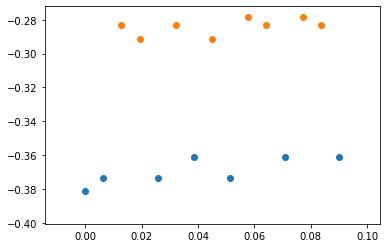

In [42]:
X = np.array((np.linspace(0,.09,15).transpose(),t[0: 36*g+36: 36].transpose())).T

# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot

# define the model
model = GaussianMixture(n_components=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

In [43]:
def pErr(a, b):
    return abs((a - b)/ (b))

In [44]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(4,)))


model.add(tf.keras.layers.Dense(128, activation='tanh'))
model.add(tf.keras.layers.Dense(32, activation='tanh'))

model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(500, activation='relu'))

model.add(tf.keras.layers.Dense(3))

model.compile(optimizer='adam', loss=los)

model.fit(x1[:6], y1[:6], epochs=1000)

arr1 = model.predict(x1[:6])*255.0

Epoch 1/1000
1/1 [==============================] - 0s 4ms/step - loss: 74077356163072.0000
Epoch 2/1000
1/1 [==============================] - 0s 3ms/step - loss: 55621927829504.0000
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 35984825647104.0000
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 20989526147072.0000
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - loss: 8280248680448.0000
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: 2702375649280.0000
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 379033616384.0000
Epoch 8/1000
1/1 [==============================] - 0s 3ms/step - loss: 13003504640.0000
Epoch 9/1000
1/1 [==============================] - 0s 3ms/step - loss: 13055234048.0000
Epoch 10/1000
1/1 [==============================] - 0s 4ms/step - loss: 299879858176.0000
Epoch 11/1000
1/1 [==============================] - 0s 634us/step - loss: 2103163486208.00

In [45]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(4,)))


model.add(tf.keras.layers.Dense(128, activation='tanh'))
model.add(tf.keras.layers.Dense(32, activation='tanh'))

model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(500, activation='relu'))

model.add(tf.keras.layers.Dense(3))


model.compile(optimizer='adam', loss=los)
print()
model.fit(x2[:5], y2[:5], epochs=1000)

arr2 = model.predict(x2[5:])*255.0


Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 56446553161728.0000
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 41983393398784.0000
Epoch 3/1000
1/1 [==============================] - 0s 997us/step - loss: 24053513453568.0000
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 11906169438208.0000
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - loss: 4597679128576.0000
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: 1249933656064.0000
Epoch 7/1000
1/1 [==============================] - 0s 4ms/step - loss: 377489326080.0000
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 263037419520.0000
Epoch 9/1000
1/1 [==============================] - 0s 4ms/step - loss: 111678930944.0000
Epoch 10/1000
1/1 [==============================] - 0s 2ms/step - loss: 209883676672.0000
Epoch 11/1000
1/1 [==============================] - 0s 998us/step - loss: 12629310177

In [46]:
def graph_fit(reh, ree, reht, g):
    curve_fit_points = []
    data2 = pd.read_csv('data.csv')
    dvcs = np.array(data['dvcs'])[g:g+36]

    phi = np.array(data2['phi_x'])[g:g+36]
    F1 = np.array(data2['F1'])[g:g+36]
    F2 = np.array(data2['F2'])[g:g+36]

    q2 = np.array(data2['QQ'])[g:g+36]
    xb = np.array(data2['x_b'])[g:g+36]
    k = np.array(data2['k'])[g:g+36]
    t = np.array(data2['t'])[g:g+36]

    F = np.array(data2['F'])[g:g+36]
    errF = np.array(data2['errF'])[g:g+36]

    for p in range(0, 36):
                  
        pars = [q2[p], xb[p], t[p], k[p], reh, ree, reh, ree, reht, dvcs[p]]
        angle = [phi[p]]
        curve_fit_points.append(func.TotalUUXS(angle, pars)) 
      
    plt.plot(phi, curve_fit_points, 'r--', alpha=0.5, label='Curve Fit') # plot the raw data
    plt.errorbar(phi, F, errF,  None, 'bo', label='t={0} x_b={1} Q={2}'.format(t[0],xb[0], q2[0]), alpha=0.8) # plot the raw data
    plt.xlabel('X value')
    plt.ylabel('Observables')
    plt.legend()
    plt.show()

Errors Set  0 :
Set 1
Real  ReH 13.0554 ReE -53.0554 ReHT 7.253019999999999
Predicted ReH 12.256984 ReE -51.532703 ReHT 6.8157077
 
Chi  ReH 0.06306624460049916 ReE 0.08157402621155244 ReHT 0.062496882532626315
ML  ReH 0.06115601536383087 ReE 0.028700124781677185 ReHT 0.06029382470154046
 


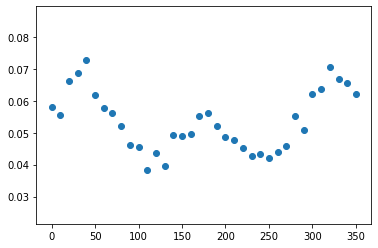

Errors Set  1 :
Set 1
Real  ReH 12.5549 ReE -52.5549 ReHT 6.974939999999999
Predicted ReH 12.262415 ReE -51.56535 ReHT 6.826614
 
Chi  ReH 0.06651456236466628 ReE 0.09149851077187778 ReHT 0.07356328618281023
ML  ReH 0.023296487247928967 ReE 0.018828889811275097 ReHT 0.021265573174012245
 


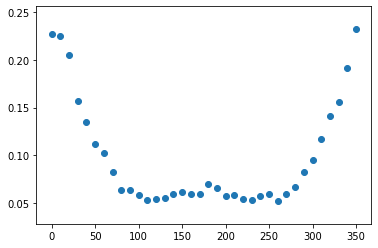

Errors Set  2 :
Set 1
Real  ReH 12.5549 ReE -52.5549 ReHT 6.974939999999999
Predicted ReH 12.358114 ReE -52.098335 ReHT 6.871386
 
Chi  ReH 0.06651456236466628 ReE 0.09149851077187778 ReHT 0.07356328618281023
ML  ReH 0.01567402029855188 ReE 0.008687386597381446 ReHT 0.014846571988005739
 


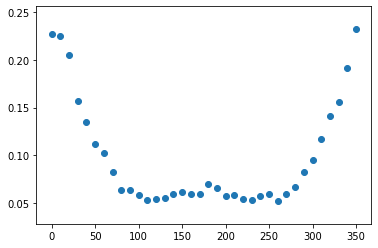

Errors Set  3 :
Set 1
Real  ReH 11.7411 ReE -51.7411 ReHT 6.52283
Predicted ReH 12.464283 ReE -52.694813 ReHT 6.9375424
 
Chi  ReH 0.133712546061349 ReE 0.17175076477240778 ReHT 0.06574362138474582
ML  ReH 0.061594142755104185 ReE 0.018432402377572182 ReHT 0.06357860598959043
 


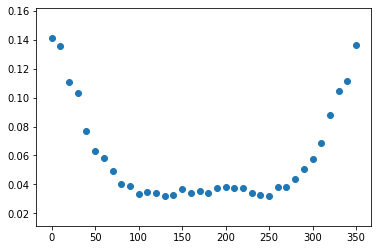

Errors Set  4 :
Set 1
Real  ReH 12.5549 ReE -52.5549 ReHT 6.974939999999999
Predicted ReH 12.453807 ReE -52.631283 ReHT 6.9161563
 
Chi  ReH 0.06651456236466628 ReE 0.09149851077187778 ReHT 0.07356328618281023
ML  ReH 0.008052085071467673 ReE 0.0014533907665409099 ReHT 0.008427844259352673
 


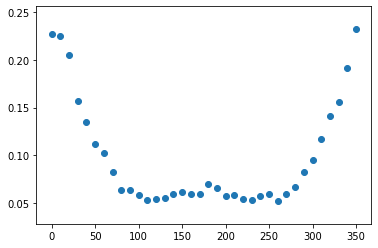

Errors Set  5 :
Set 1
Real  ReH 11.7411 ReE -51.7411 ReHT 6.52283
Predicted ReH 12.559972 ReE -53.22773 ReHT 6.982308
 
Chi  ReH 0.133712546061349 ReE 0.17175076477240778 ReHT 0.06574362138474582
ML  ReH 0.06974404522465592 ReE 0.028732087206558773 ReHT 0.07044149715985079
 


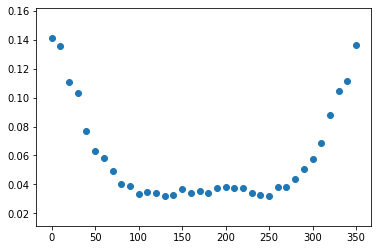

Errors Set  6 :
Set 1
Set 2
Real  ReH 7.224239999999999 ReE -47.2242 ReHT 4.01347
Predicted ReH 7.44351 ReE -47.817673 ReHT 4.1297565
 
Chi  ReH 0.09459516432642315 ReE 0.08530219227052974 ReHT 0.11741215571979306
ML  ReH 0.03035198935002064 ReE 0.012567131459975693 ReHT 0.028974042574898107
 


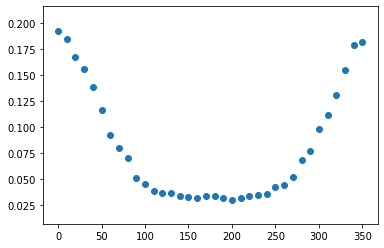

Errors Set  7 :
Set 1
Set 2
Real  ReH 7.6527199999999995 ReE -47.6527 ReHT 4.25151
Predicted ReH 7.451062 ReE -48.192585 ReHT 4.166108
 
Chi  ReH 0.17371803363555113 ReE 0.14339344015608185 ReHT 0.06222013051317005
ML  ReH 0.026351127121649068 ReE 0.01132957820763724 ReHT 0.020087420373304608
 


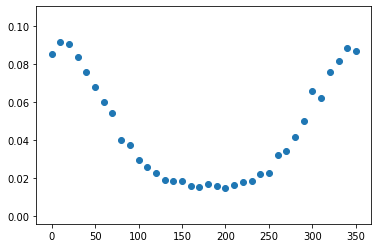

Errors Set  8 :
Set 1
Set 2
Real  ReH 7.224239999999999 ReE -47.2242 ReHT 4.01347
Predicted ReH 7.4639187 ReE -48.2265 ReHT 4.1532187
 
Chi  ReH 0.09459516432642315 ReE 0.08530219227052974 ReHT 0.11741215571979306
ML  ReH 0.03317701044166402 ReE 0.021224318566407618 ReHT 0.03481993043060067
 


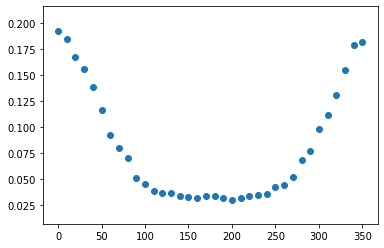

In [49]:
p, d = 0, 0
for i in range(0, 9):#iters):
    
    print("Errors Set ", i,":" )
    try:
        print("Set 1")
        
        a = np.where(reh == y1[p][0]*255)
        b = np.where(ree == y1[p][1]*255)
        c = np.where(reht == y1[p][2]*255)
        g = (a and b and c)[0][0]
        
        params_fit = chi_fit(g)
        
        
        reh_chi = pErr(params_fit[0], y1[p][0]*255)
        ree_chi = pErr(params_fit[1], y1[p][1]*255)
        reht_chi = pErr(params_fit[2], y1[p][2]*255)
        
        reh_ml = pErr(arr1[p][0], y1[p][0]*255)
        ree_ml = pErr(arr1[p][1], y1[p][1]*255)
        reht_ml = pErr(arr1[p][2], y1[p][2]*255)
        
        print("Real  ReH", (y1[p][0]*255), "ReE", (y1[p][1]*255), "ReHT", (y1[p][2]*255))
        print("Predicted ReH", arr1[p][0], "ReE", arr1[p][1], "ReHT", arr1[p][2] )
        
        p = p+1
        
        
    except:
        print("Set 2")
        a = np.where(reh == y2[d][0]*255)
        b = np.where(ree == y2[d][1]*255)
        c = np.where(reht == y2[d][2]*255)
        g = (a and b and c)[0][0]
        
        params_fit = chi_fit(g)
        
        reh_chi = pErr(params_fit[0] , y2[d][0]*255)
        ree_chi = pErr(params_fit[1] , y2[d][1]*255)
        reht_chi = pErr(params_fit[2] , y2[d][2]*255)
        
        reh_ml = pErr(arr2[d][0], y2[d][0]*255)
        ree_ml = pErr(arr2[d][1], y2[d][1]*255)
        reht_ml = pErr(arr2[d][2], y2[d][2]*255)
        
        print("Real  ReH", (y2[d][0]*255), "ReE", (y2[d][1]*255), "ReHT", (y2[d][2]*255))
        print("Predicted ReH", arr2[d][0], "ReE", arr2[d][1], "ReHT", arr2[d][2] )
        
        d=d+1
        

    print(" ")
    print("Chi  ReH", abs(reh_chi), "ReE", abs(ree_chi), "ReHT", abs(reht_chi))
    print("ML  ReH", abs(reh_ml), "ReE", abs(ree_ml), "ReHT", abs(reht_ml))
    print(" ")
        
    if abs(reh_ml) > 0.1:
        print("ERROR Greater than 10%")
    
    data1 = pd.read_csv('data.csv')
    phi = np.array(data1['phi_x'])[g:g+36]
    F = np.array(data1['F'])[g:g+36]
    errF = np.array(data1['errF'])[g:g+36]
    
    plt.scatter(phi, F)#, errF)
    plt.show()